In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from nlp_module import normalize_corpus, remove_stopwords
from wordcloud import WordCloud, STOPWORDS
import gc
import time
from langdetect import detect
import spacy
from spacy import displacy
from tqdm import tqdm
import nltk
import re
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

In [2]:
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

In [3]:
#pip install wordcloud

In [4]:
# Install langdetect
#!pip install langdetect

# Importation et description des données

J'ai téléchargé les données à travers la requete SQL suivante sur le site: https://data.stackexchange.com/stackoverflow/query/

SELECT Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount

FROM Posts 

WHERE PostTypeId = 1 AND ViewCount > 0 AND FavoriteCount > 0

AND Score > 0 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [5]:
data = pd.read_csv("QueryResults .csv", sep=',')

In [6]:
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,PyQt - Dialog in another thread,<p>my program has a main window and in this wi...,<python><multithreading><qt><dialog><pyqt>,39580473,2,6464,2,2
1,Action Cable and AngularJS Cross Domain Integr...,<p>I currently have a Rails 5 application acti...,<ruby-on-rails><angularjs><websocket><cross-do...,39923514,5,1107,2,1
2,Cannot create mockito mock with __exit__ method,<p>I am not able to attach <code>__exit__</cod...,<python><unit-testing><mockito><attributeerror...,54676909,1,113,1,1
3,Why Integrating Spring Cloud application with ...,<p><strong>Intent</strong> : I am working on a...,<java><amazon-web-services><spring-boot><sprin...,54050702,2,5102,3,1
4,Away3D vs Sandy 3D and other Flash 3D Engines ...,<p>What are the pros and cons of various Flash...,<flash><mobile><3d><away3d><sandy3d>,3120078,2,730,1,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Id             50000 non-null  int64 
 4   Score          50000 non-null  int64 
 5   ViewCount      50000 non-null  int64 
 6   FavoriteCount  50000 non-null  int64 
 7   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [8]:
print((data.isnull().mean()\
       *100).round(2))

Title            0.0
Body             0.0
Tags             0.0
Id               0.0
Score            0.0
ViewCount        0.0
FavoriteCount    0.0
AnswerCount      0.0
dtype: float64


In [9]:
data.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.000000,5.000000e+04,50000.00000,50000.000000
mean,1.986932e+07,18.857160,1.771846e+04,7.08802,2.912220
std,1.757979e+07,145.378913,9.711838e+04,66.54665,3.343516
min,4.000000e+00,1.000000,2.400000e+01,1.00000,1.000000
25%,4.203690e+06,2.000000,1.230000e+03,1.00000,1.000000
50%,1.834877e+07,4.000000,3.249500e+03,2.00000,2.000000
75%,3.653442e+07,9.000000,9.737250e+03,3.00000,3.000000
max,6.903617e+07,11122.000000,4.761794e+06,6726.00000,125.000000


Le jeu de données ne compte pas de valeurs nulles. La variable Id ne compte que des valeurs uniques, nous pouvons donc l'utiliser en index :

In [10]:
data.set_index('Id', inplace=True)

# Data exploration

Nous allons vérifier la longeur des différents titres

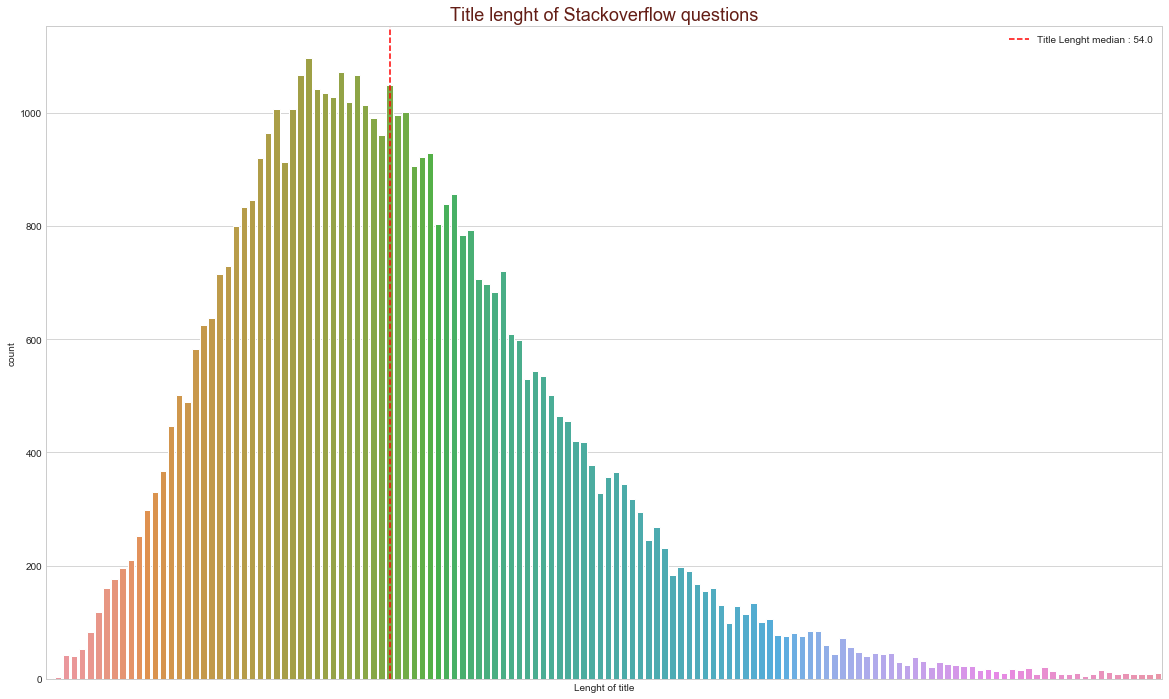

In [11]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.Title.str.len())
start, end = data.Title.str.len().min(),data.Title.str.len().max()
ax.xaxis.set_ticks([])#np.arange(0, end, 5))
plt.axvline(data.Title.str.len().median() - start,
            color="r", linestyle='--',
            label="Title Lenght median : "+str(data.Title.str.len().median()))
ax.set_xlabel("Lenght of title")
plt.title("Title lenght of Stackoverflow questions",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

### Analyse des tags

Nous allons faire une rapide analyse exploratoire sur les tags de notre jeu de données.

In [12]:
data['Tags'].head(3)

Id
39580473           <python><multithreading><qt><dialog><pyqt>
39923514    <ruby-on-rails><angularjs><websocket><cross-do...
54676909    <python><unit-testing><mockito><attributeerror...
Name: Tags, dtype: object

Nous allons modifier les séparateurs de Tags pour favoriser les extractions :

In [13]:
# Replace open and close balise between tags
data['Tags'] = data['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))

# Delete last "," for each row
data['Tags'] = data['Tags'].str[:-1]
data['Tags'].head(3)

Id
39580473                 python,multithreading,qt,dialog,pyqt
39923514    ruby-on-rails,angularjs,websocket,cross-domain...
54676909    python,unit-testing,mockito,attributeerror,con...
Name: Tags, dtype: object

Les tags contenus dans la variable Tags sont ensuite splités et ajoutés dans une liste pour ensuite les classer :

In [14]:
def count_split_tags(df, column, separator):
    """This function allows you to split the different words contained
    in a Pandas Series cell and to inject them separately into a list.
    This makes it possible, for example, to count the occurrences of words.

    Parameters
    ----------------------------------------
    df : Pandas Dataframe
        Dataframe to use.
    column : string
        Column of the dataframe to use
    separator : string
        Separator character for str.split.
    ----------------------------------------
    """
    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [15]:
tags_list = count_split_tags(df=data, column='Tags', separator=',')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 18577 tags.


In [16]:
tags_list

,tag_count
Tag,
c#,6365
java,6032
javascript,5020
python,4134
c++,3385
...,...
azure-cdn,1
mobilenet,1
mobipocket,1


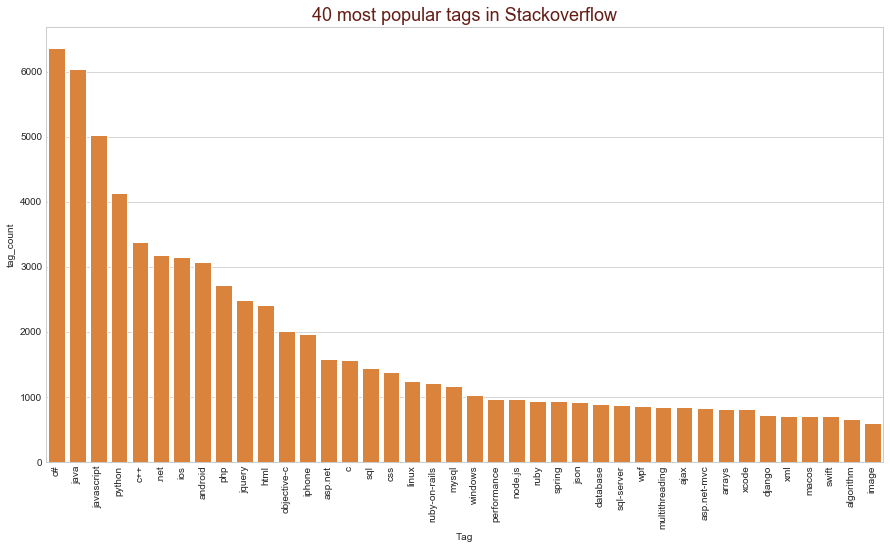

In [17]:
# Plot the results of splits
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:40, :],
            x=tags_list.iloc[0:40, :].index,
            y="tag_count", color="#f48023")
plt.xticks(rotation=90)
plt.title("40 most popular tags in Stackoverflow",
          fontsize=18, color="#641E16")
plt.show()

Dans les 40 tags les plus populaires sur StackOverflow, les tags  C#, java et javascript sont sans surprise dans le top 3. 

Nous pouvons également ***visualiser les 500 premières catégories dans un nuage de mots*** :

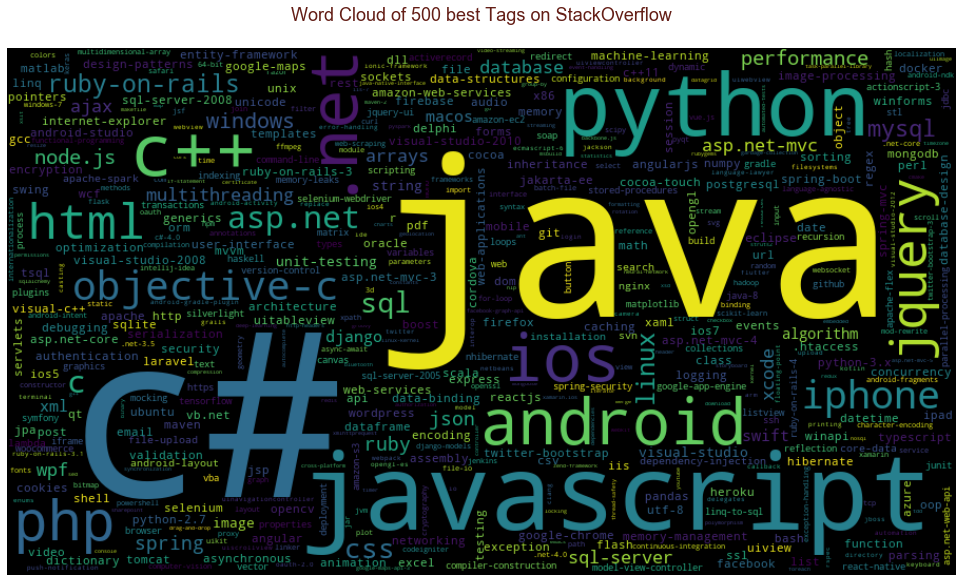

In [18]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(tags_list.to_dict()['tag_count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()


### Filtrage du jeu de données avec les meilleurs Tags :

Les process de NLP sont des algorithmes assez lents compte tenu de la quantité de données à traiter. Pour filtrer notre jeu de données, nous allons sélectionner toutes les questions qui comportent au minimum un des 50 meilleurs tags et supprimer les autres tags :

In [19]:
def filter_tag(x, top_list):
    """Comparison of the elements of 2 lists to 
    check if all the tags are found in a list of top tags.

    Parameters
    ----------------------------------------
    x : list
        List of tags to test.
    ----------------------------------------
    """
    temp_list = []
    for item in x:
        if (item in top_list):
            #x.remove(item)
            temp_list.append(item)
    return temp_list

In [23]:
data['Tags_list'] = data['Tags'].str.split(',')
top_tags = list(tags_list.iloc[0:50].index)
data['Tags_list'] = data['Tags_list'].apply(lambda x: filter_tag(x, top_tags))
data['number_of_tags'] = data['Tags_list'].apply(lambda x : len(x))
data = data[data.number_of_tags > 0]
print("New size of dataset : {} questions.".format(data.shape[0]))

New size of dataset : 43348 questions.


In [24]:
data.head()

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount,Tags_list,number_of_tags
Id,,,,,,,,,
39580473,PyQt - Dialog in another thread,<p>my program has a main window and in this wi...,"python,multithreading,qt,dialog,pyqt",2,6464,2,2,"[python, multithreading]",2
39923514,Action Cable and AngularJS Cross Domain Integr...,<p>I currently have a Rails 5 application acti...,"ruby-on-rails,angularjs,websocket,cross-domain...",5,1107,2,1,"[ruby-on-rails, angularjs]",2
54676909,Cannot create mockito mock with __exit__ method,<p>I am not able to attach <code>__exit__</cod...,"python,unit-testing,mockito,attributeerror,con...",1,113,1,1,"[python, unit-testing]",2
54050702,Why Integrating Spring Cloud application with ...,<p><strong>Intent</strong> : I am working on a...,"java,amazon-web-services,spring-boot,spring-cl...",2,5102,3,1,[java],1
37292032,Add custom header to all Swagger responses in ...,<p>We are having WebApi server with Swagger fo...,"c#,.net,asp.net-web-api,swagger,swashbuckle",3,1463,1,1,"[c#, .net]",2


In [25]:
data.to_csv("data_emb.csv", index= False)

# Nettoyage des questions

Afin de traiter au mieux les données textuelles du Body, il est nécessaire de réaliser plusieurs tâches de data cleaning. Par exemple, le texte stocké dans cette variable est au format HTML. Ces balises vont polluer notre analyse. Nous allons donc supprimer toutes les balises HTML avec la librairie BeautifulSoup pour ne conserver que le texte brut.

Mais avant cette opération,nous allons supprimer tout le contenu placé entre 2 balises html <code></code>, cela nous permettra de supprimer tout le code brut souvent copié dans les questions Stackoverflow et qui pourrait avoir un fort impact pour la suite.

In [222]:
def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace 
    the content of all the <code> </code> tags of a text specified as a parameter.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [223]:
start_time = time.time()
# Delete <code> in Body text
data['Body'] = data['Body'].apply(remove_code)
# Delete all html tags
data['Body'] = [BeautifulSoup(text,"lxml").get_text() for text in data['Body']]
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body'].head(3))

--------------------------------------------------
Execution time : 57.67s
--------------------------------------------------
Id
39580473    my program has a main window and in this windo...
39923514    I currently have a Rails 5 application acting ...
54676909    I am not able to attach   method to a mockito ...
Name: Body, dtype: object


A présent, nous devons ***vérifier si les textes des questions sont rédigés en diverses langues***. Cela nous permettra de définir la liste des stop words à éliminer :

In [224]:
# Create feature "lang" with langdetect library
def detect_lang(x):
    try:
        return detect(x)
    except:
        pass

start_time = time.time()
data['short_body'] = data['Body'].apply(lambda x: x[0:100])
data['lang'] = data.short_body.apply(detect_lang)
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)

--------------------------------------------------
Execution time : 218.73s
--------------------------------------------------


In [225]:
# Count titles for each language
pd.DataFrame(data.lang.value_counts())

,lang
en,43288
da,10
ca,8
fr,8
no,7
it,6
af,4
nl,2
sv,2
et,1


La langue Anglaise est très majoritairement représentée dans notre dataset. Nous allons donc ***supprimer de notre jeu de données tous les post dans une autre langue que l'anglais***.

In [226]:
# Deletion of data that is not in the English language
data = data[data['lang']=='en']

Maintenant que nous avons un texte brut débarassé de ses balises HTML et du code, nous allons utiliser nltk.pos_tag pour identifier la nature de chaque mot du corpus afin de pouvoir ensuite conserver uniquement les noms. Nous allons ici créer une function qui sera appliquée ensuite dans un cleaner plus complet 

In [227]:
def remove_pos(nlp, x, pos_list):
    doc = nlp(x)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower().replace("c #", "c#")
    return join_text_row

Nous allons à présent réaliser plusieurs opérations de Text cleaning pour que nos données soient exploitables par les algorithmes de NLP :

Suppression de tous les mots autres que ***les noms***

Mettre tout le texte en ***minuscules***

Supprimer les ***caractères Unicode*** (comme les Emojis par exemple)

Suppression des ***espaces supplémentaires***

Suppression de la ***ponctuation***

Suppression des ***liens***

Supprimer les ***nombres***

In [232]:
def text_cleaner(x, nlp, pos_list):
    """Function allowing to carry out the preprossessing on the textual data. 
        It allows you to remove extra spaces, unicode characters, 
        English contractions, links, punctuation and numbers.
        
        The re library for using regular expressions must be loaded beforehand.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    # Remove POS not in "NOUN", "PROPN"
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x

In [229]:
# Install spaCy 
#import sys
#!{sys.executable} -m pip install spacy

# Download spaCy's  'en' Model
#!{sys.executable} -m spacy download en

In [238]:
#!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [241]:
#Apply cleaner on Body
# Spacy features
nlp = spacy.load('en_core_web_sm', exclude=['ner', 'parser'])
pos_list = ["NOUN","PROPN"]

start_time = time.time()
print('-' * 50)
print("Start Body cleaning ...")
print('-' * 50)

tqdm.pandas()
data['Body_cleaned'] = data.Body.progress_apply(lambda x : text_cleaner(x, nlp, pos_list))

exec_time = time.time() - start_time
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Start Body cleaning ...
--------------------------------------------------


100%|██████████| 43288/43288 [09:04<00:00, 79.56it/s]  

Execution time : 544.13s
--------------------------------------------------
Id
39580473    program window window thread power photodetect...
39923514    rails application backend core rails applicati...
54676909    method mockito mock test mock statement exampl...
Name: Body_cleaned, dtype: object


In [242]:
data['Body_cleaned'].head(10)

Id
39580473    program window window thread power photodetect...
39923514    rails application backend core rails applicati...
54676909    method mockito mock test mock statement exampl...
54050702    intent poc aws parameter store property store ...
37292032    webapi server swagger endpoints content securi...
21319729    array array filters eg filtering category type...
21319737    site php memcache users friends point thinking...
11761       web service data json file web service file ti...
19546324    mavericks yesterday development environment so...
36376179    code threads time threads app flow approaches ...
Name: Body_cleaned, dtype: object

Nous pouvons à présent ***supprimer tous les stop words en langue Anglaise*** grâce à la librairie NLTK. 

Avant cette étape, nous allons réaliser une ***tockenisation*** c'est à dire découper les phrase en mots et création d'une liste (chaque phrase est une liste de mots)

In [243]:
import nltk
#nltk.download('punkt')

In [244]:
start_time = time.time()
# Tockenization
data['Body_cleaned'] = data.Body_cleaned.apply(nltk.tokenize.word_tokenize)

# List of stop words in "EN" from NLTK
stop_words = stopwords.words("english")

# Remove stop words
data['Body_cleaned'] = data.Body_cleaned\
    .apply(lambda x : [word for word in x
                       if word not in stop_words
                       and len(word)>2])
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Execution time : 16.24s
--------------------------------------------------
Id
39580473    [program, window, window, thread, power, photo...
39923514    [rails, application, backend, core, rails, app...
54676909    [method, mockito, mock, test, mock, statement,...
Name: Body_cleaned, dtype: object


A présent, nous avons des listes de mots débarrassées des mots courants (stop words), de la ponctuation, des liens et des nombres. Une dernière étape que nous pouvons effectuer est la Lemmatisation. Ce procédé consiste à prend le mot à sa forme racine appelée Lemme. Cela nous permet d'amener les mots à leur forme "dictionnaire". Nous allons pour cela utiliser à nouveau la librairie NLTK.

In [245]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [246]:
from nltk.stem.wordnet import WordNetLemmatizer
# Apply lemmatizer on Body
start_time = time.time()
wn = WordNetLemmatizer()
data['Body_cleaned'] = data.Body_cleaned\
    .apply(lambda x : [wn.lemmatize(word) for word in x])
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Execution time : 7.10s
--------------------------------------------------
Id
39580473    [program, window, window, thread, power, photo...
39923514    [rail, application, backend, core, rail, appli...
54676909    [method, mockito, mock, test, mock, statement,...
Name: Body_cleaned, dtype: object


## Nettoyage des titres

Nous avons préalablement défini une fonction pour notre cleaning des Body. Nous allons la modifier pour y intégrer la tokenisation, les stop words et la lemmanisation afin d'obtenir un processus complet à appliquer aux titres des posts.

In [248]:
def text_cleaner(x, nlp, pos_list, lang="english"):
    """Function allowing to carry out the preprossessing on the textual data. 
        It allows you to remove extra spaces, unicode characters, 
        English contractions, links, punctuation and numbers.
        
        The re library for using regular expressions must be loaded beforehand.
        The SpaCy and NLTK librairies must be loaded too. 

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    # Remove POS not in "NOUN", "PROPN"
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
        
    # Tokenization
    x = nltk.tokenize.word_tokenize(x)
    # List of stop words in select language from NLTK
    stop_words = stopwords.words(lang)
    # Remove stop words
    x = [word for word in x if word not in stop_words 
         and len(word)>2]
    # Lemmatizer
    wn = nltk.WordNetLemmatizer()
    x = [wn.lemmatize(word) for word in x]
    
    # Return cleaned text
    return x

In [250]:
# Spacy features
nlp = spacy.load("en_core_web_sm", exclude=['ner', 'parser'])
pos_list = ["NOUN","PROPN"]
# Apply full cleaner on Title
print('-' * 50)
print("Start Title cleaning ...")
print('-' * 50)
start_time = time.time()
data['Title_cleaned'] = data.Title\
                            .progress_apply(lambda x: 
                                            text_cleaner(x, nlp,
                                                         pos_list,
                                                         "english"
                                                         ))
exec_time = time.time() - start_time
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Title_cleaned'].head(3))

--------------------------------------------------
Start Title cleaning ...
--------------------------------------------------


100%|██████████| 43288/43288 [02:42<00:00, 265.59it/s]

Execution time : 163.01s
--------------------------------------------------
Id
39580473                               [pyqt, dialog, thread]
39923514    [action, cable, angularjs, cross, domain, inte...
54676909                        [mockito, mock, exit, method]
Name: Title_cleaned, dtype: object


Nous pouvons à présent projeter la distribution de la taille des tokens Title et le nuage de mots correspondant aux 500 meilleurs apparitions :

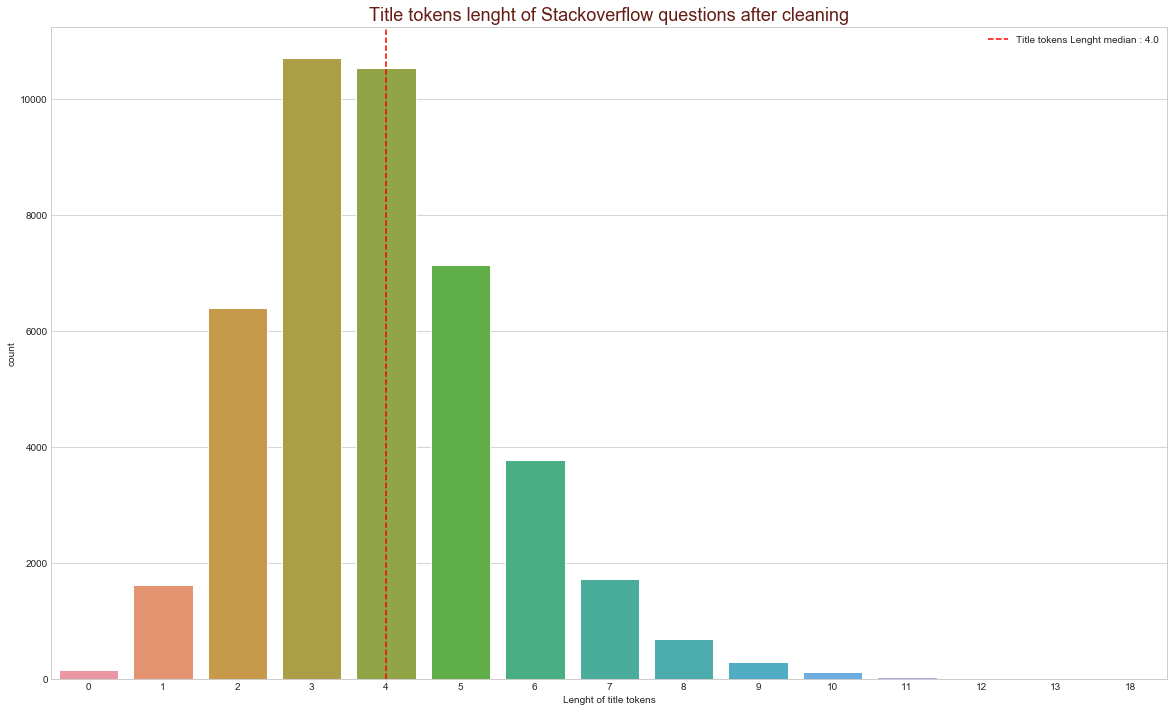

In [251]:
# Calculate lenght of each list in Title
data['Title_tokens_count'] = [len(_) for _ in data.Title_cleaned]

# Countplot of Title lenght
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.Title_tokens_count)
median_plot = data.Title_tokens_count.median()
plt.axvline(median_plot - data.Title_tokens_count.min(),
            color="r", linestyle='--',
            label="Title tokens Lenght median : "+str(median_plot))
ax.set_xlabel("Lenght of title tokens")
plt.title("Title tokens lenght of Stackoverflow questions after cleaning",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

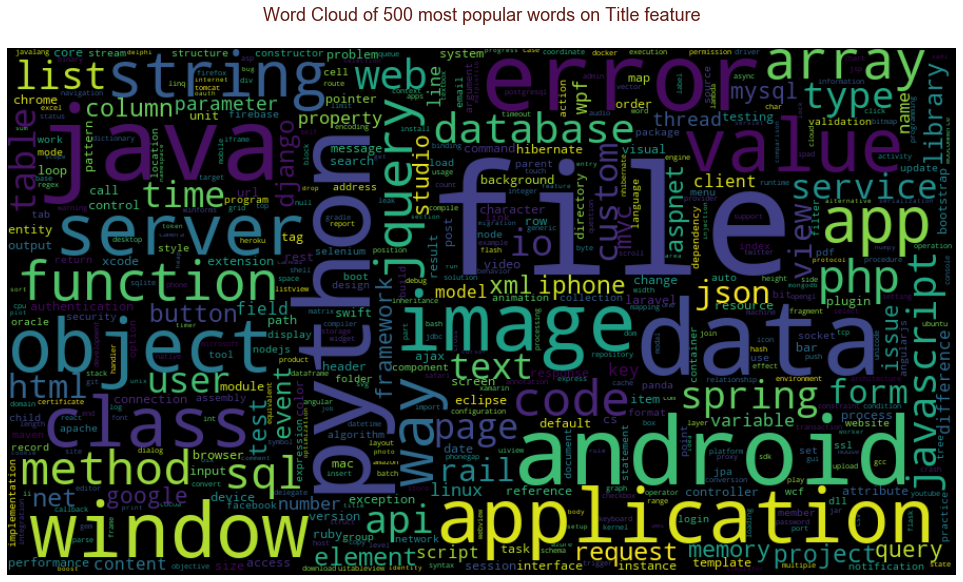

In [252]:
# Create a list of all tokens for Title
full_corpus_t = []
for i in data['Title_cleaned']:
    full_corpus_t.extend(i)

# Calculate distribition of words in Title token list
title_dist = nltk.FreqDist(full_corpus_t)
title_dist = pd.DataFrame(title_dist.most_common(500),
                          columns=['Word', 'Frequency'])

# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(title_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 most popular words on Title feature\n",
          fontsize=18, color="#641E16")
plt.show()

## Export du dataset nettoyé

In [253]:
# Remove calculated features
data = data[['Title_cleaned',
             'Body_cleaned',
             'Score',
             'Tags_list']]
# Rename columns
data = data.rename(columns={'Title_cleaned': 'Title',
                            'Body_cleaned': 'Body',
                            'Tags_list': 'Tags'})
data.head(3)

,Title,Body,Score,Tags
Id,,,,
39580473,"[pyqt, dialog, thread]","[program, window, window, thread, power, photo...",2,"[python, multithreading]"
39923514,"[action, cable, angularjs, cross, domain, inte...","[rail, application, backend, core, rail, appli...",5,"[ruby-on-rails, angularjs]"
54676909,"[mockito, mock, exit, method]","[method, mockito, mock, test, mock, statement,...",1,"[python, unit-testing]"


In [254]:
data.to_csv("data_cleaned.csv", index= False)